## 0.0 Import Packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_criteo
from sklift.metrics import (
    qini_auc_score,
    uplift_at_k,
    uplift_auc_score,
    uplift_by_percentile,
)
from sklift.viz import (
    plot_qini_curve,
    plot_uplift_curve,
    plot_uplift_by_percentile,
)

pd.set_option("display.max_columns", 1200)

/Users/luna/anaconda3/envs/yh_py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.1 Utils

In [2]:
def get_metrics(y, uplift_effect, treatment):
    no_effect_share = round(100 * np.sum(uplift_effect == 0) / len(uplift_effect), 2)
    positive_effect_share = round(
        100 * np.sum(uplift_effect > 0) / len(uplift_effect), 2
    )
    negative_effect_share = round(
        100 * np.sum(uplift_effect < 0) / len(uplift_effect), 2
    )
    print(
        f"Model predicts positive effect in conversion after treatment for {positive_effect_share}% of cases."
    )
    print(
        f"Model predicts negative effect in conversion after treatment for {negative_effect_share}% of cases."
    )
    print(
        f"Model predicts no effect in conversion after treatment for {no_effect_share}% of cases."
    )

    uplift_at_10 = uplift_at_k(y, uplift_effect, treatment, strategy="overall", k=0.1)
    qini_coef = qini_auc_score(y, uplift_effect, treatment)
    uplift_auc = uplift_auc_score(y, uplift_effect, treatment)
    print(f"Uplift at 10% by overall: {uplift_at_10}")
    print(f"Qini coefficient - AUQC: {qini_coef}")
    print(f"Uplift AUC - AUUC: {uplift_auc}")

## 1.0 Data Exploration

In [3]:
dataset = fetch_criteo(target_col="conversion", treatment_col="treatment")
features, target, treatment = dataset.data, dataset.target, dataset.treatment

### 1.1 Features Description

In [5]:
features.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01


In [6]:
target.value_counts(normalize=True)

0    0.997083
1    0.002917
Name: conversion, dtype: Float64

In [9]:
treatment.value_counts(normalize=True)

1    0.85
0    0.15
Name: treatment, dtype: Float64

### 1.2 Train-Validation-Holdout Split

- Train: 80%
- Validation: 10%
- Holdout (Test): 10%

In [4]:
RANDOM_SEED = 42
VALIDATION_SIZE = 0.1
HOLDOUT_SIZE = 0.1

stratify_cols = pd.concat([treatment, target], axis=1)
(
    X_train_val,
    X_holdout,
    y_train_val,
    y_holdout,
    trmnt_train_val,
    trmnt_holdout,
) = train_test_split(
    features,
    target,
    treatment,
    test_size=HOLDOUT_SIZE,
    random_state=RANDOM_SEED,
    stratify=stratify_cols,
)

X_train, X_val, y_train, y_val, trmnt_train, trmnt_val = train_test_split(
    X_train_val,
    y_train_val,
    trmnt_train_val,
    test_size=VALIDATION_SIZE / (1 - HOLDOUT_SIZE),
    random_state=RANDOM_SEED,
    stratify=stratify_cols.loc[X_train_val.index],
)

In [4]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_holdout.value_counts(normalize=True))

0    0.997083
1    0.002917
Name: conversion, dtype: Float64
0    0.997084
1    0.002916
Name: conversion, dtype: Float64
0    0.997084
1    0.002916
Name: conversion, dtype: Float64


In [5]:
print(trmnt_train.value_counts(normalize=True))
print(trmnt_val.value_counts(normalize=True))
print(trmnt_holdout.value_counts(normalize=True))

1    0.85
0    0.15
Name: treatment, dtype: Float64
1    0.85
0    0.15
Name: treatment, dtype: Float64
1    0.85
0    0.15
Name: treatment, dtype: Float64


### 1.3 Add treatment flag as a feature

In [5]:
X_train["f12_trmnt"] = trmnt_train.astype(int)
X_val["f12_trmnt"] = trmnt_val.astype(int)

## 2.0 Modelling

In [6]:
IS_UNBALANCE = True
N_ESTIMATORS = 1000

y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_holdout = y_holdout.astype(int)

### 2.1 Optuna Hyperparameter Tuning

In [7]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 5e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 3, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1e2, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1e2, log=True),
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 1e-3, 1e2, log=True
        ),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 100),
        "n_estimators": N_ESTIMATORS,
        "objective": "binary",
        "random_state": RANDOM_SEED,
        "boosting_type": "gbdt",
        "importance_type": "gain",
        "is_unbalance": IS_UNBALANCE,
        "verbose": -1,
    }

    model = LGBMClassifier(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
    )

    auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    return auc


study_lgbm = optuna.create_study(direction="maximize", study_name="lgbm_s_learner")
study_lgbm.optimize(objective, n_trials=5)  # increase n_trials to get better results
best_params = study_lgbm.best_params
print(f"Best params: {best_params}")
print(f"Best value: {study_lgbm.best_value}")

[I 2025-03-02 15:41:58,689] A new study created in memory with name: lgbm_s_learner


[LightGBM] [Warning] early_stopping_round is set=94, early_stopping_rounds=94 will be ignored. Current value: early_stopping_round=94
[1]	valid_0's binary_logloss: 3.25059
[2]	valid_0's binary_logloss: 0.240406
[3]	valid_0's binary_logloss: 3.30225
[4]	valid_0's binary_logloss: 3.40771
[5]	valid_0's binary_logloss: 2.78672
[6]	valid_0's binary_logloss: 2.97766
[7]	valid_0's binary_logloss: 2.89642
[8]	valid_0's binary_logloss: 3.81713
[9]	valid_0's binary_logloss: 3.73209
[10]	valid_0's binary_logloss: 3.72768
[11]	valid_0's binary_logloss: 3.42502
[12]	valid_0's binary_logloss: 3.37729
[13]	valid_0's binary_logloss: 3.70696
[14]	valid_0's binary_logloss: 3.36031
[15]	valid_0's binary_logloss: 3.33147
[16]	valid_0's binary_logloss: 3.37484
[17]	valid_0's binary_logloss: 3.341
[18]	valid_0's binary_logloss: 3.31709
[19]	valid_0's binary_logloss: 3.3044
[20]	valid_0's binary_logloss: 3.27808
[21]	valid_0's binary_logloss: 3.24966
[22]	valid_0's binary_logloss: 3.21034
[23]	valid_0's bina

[I 2025-03-02 15:43:21,388] Trial 0 finished with value: 0.095915976805212 and parameters: {'learning_rate': 0.11200908284106999, 'num_leaves': 202, 'min_child_samples': 18, 'subsample': 0.754986547908107, 'colsample_bytree': 0.6710282275711111, 'reg_alpha': 0.0016826547928393233, 'reg_lambda': 10.784249002354684, 'min_child_weight': 0.035354483137566714, 'early_stopping_rounds': 94}. Best is trial 0 with value: 0.095915976805212.


[LightGBM] [Warning] early_stopping_round is set=44, early_stopping_rounds=44 will be ignored. Current value: early_stopping_round=44
[1]	valid_0's binary_logloss: 0.0185842
[2]	valid_0's binary_logloss: 0.0179865
[3]	valid_0's binary_logloss: 0.0176928
[4]	valid_0's binary_logloss: 0.017647
[5]	valid_0's binary_logloss: 0.0175882
[6]	valid_0's binary_logloss: 0.0176108
[7]	valid_0's binary_logloss: 0.0176712
[8]	valid_0's binary_logloss: 0.0178279
[9]	valid_0's binary_logloss: 0.0179323
[10]	valid_0's binary_logloss: 0.0181316
[11]	valid_0's binary_logloss: 0.0182826
[12]	valid_0's binary_logloss: 0.0184509
[13]	valid_0's binary_logloss: 0.0186402
[14]	valid_0's binary_logloss: 0.0188337
[15]	valid_0's binary_logloss: 0.0190428
[16]	valid_0's binary_logloss: 0.0192501
[17]	valid_0's binary_logloss: 0.019469
[18]	valid_0's binary_logloss: 0.0197016
[19]	valid_0's binary_logloss: 0.0199449
[20]	valid_0's binary_logloss: 0.0201748
[21]	valid_0's binary_logloss: 0.0204163
[22]	valid_0's b

[I 2025-03-02 15:44:14,879] Trial 1 finished with value: 0.9580110053056197 and parameters: {'learning_rate': 0.002506777273248653, 'num_leaves': 117, 'min_child_samples': 19, 'subsample': 0.9103849118305263, 'colsample_bytree': 0.5752851674154185, 'reg_alpha': 0.340465524714597, 'reg_lambda': 0.3608582251010709, 'min_child_weight': 0.29541594603603627, 'early_stopping_rounds': 44}. Best is trial 1 with value: 0.9580110053056197.


[LightGBM] [Warning] early_stopping_round is set=78, early_stopping_rounds=78 will be ignored. Current value: early_stopping_round=78
[1]	valid_0's binary_logloss: 7.48635
[2]	valid_0's binary_logloss: 0.313184
[3]	valid_0's binary_logloss: 3.0523
[4]	valid_0's binary_logloss: 2.93255
[5]	valid_0's binary_logloss: 9.1067
[6]	valid_0's binary_logloss: 9.13131
[7]	valid_0's binary_logloss: 8.9759
[8]	valid_0's binary_logloss: 8.89137
[9]	valid_0's binary_logloss: 8.73475
[10]	valid_0's binary_logloss: 8.68568
[11]	valid_0's binary_logloss: 8.45341
[12]	valid_0's binary_logloss: 9.28939
[13]	valid_0's binary_logloss: 9.25731
[14]	valid_0's binary_logloss: 11.304
[15]	valid_0's binary_logloss: 5.76784
[16]	valid_0's binary_logloss: 5.62183
[17]	valid_0's binary_logloss: 4.81745
[18]	valid_0's binary_logloss: 5.06694
[19]	valid_0's binary_logloss: 5.14815
[20]	valid_0's binary_logloss: 5.54254
[21]	valid_0's binary_logloss: 5.34652
[22]	valid_0's binary_logloss: 5.38935
[23]	valid_0's binar

[I 2025-03-02 15:45:14,681] Trial 2 finished with value: 0.134112875663687 and parameters: {'learning_rate': 0.25774003963764575, 'num_leaves': 43, 'min_child_samples': 33, 'subsample': 0.827209629179588, 'colsample_bytree': 0.7508276875768941, 'reg_alpha': 24.69057978392288, 'reg_lambda': 0.20783445156188382, 'min_child_weight': 0.0018624494763411395, 'early_stopping_rounds': 78}. Best is trial 1 with value: 0.9580110053056197.


[LightGBM] [Warning] early_stopping_round is set=54, early_stopping_rounds=54 will be ignored. Current value: early_stopping_round=54
[1]	valid_0's binary_logloss: 0.122779
[2]	valid_0's binary_logloss: 0.12534
[3]	valid_0's binary_logloss: 0.127848
[4]	valid_0's binary_logloss: 0.130253
[5]	valid_0's binary_logloss: 0.132597
[6]	valid_0's binary_logloss: 0.134972
[7]	valid_0's binary_logloss: 0.137261
[8]	valid_0's binary_logloss: 0.139512
[9]	valid_0's binary_logloss: 0.141593
[10]	valid_0's binary_logloss: 0.14374
[11]	valid_0's binary_logloss: 0.145723
[12]	valid_0's binary_logloss: 0.147736
[13]	valid_0's binary_logloss: 0.149739
[14]	valid_0's binary_logloss: 0.151594
[15]	valid_0's binary_logloss: 0.153526
[16]	valid_0's binary_logloss: 0.155294
[17]	valid_0's binary_logloss: 0.157082
[18]	valid_0's binary_logloss: 0.158942
[19]	valid_0's binary_logloss: 0.160727
[20]	valid_0's binary_logloss: 0.1625
[21]	valid_0's binary_logloss: 0.164213
[22]	valid_0's binary_logloss: 0.165773

[I 2025-03-02 15:47:04,156] Trial 3 finished with value: 0.9521796137666604 and parameters: {'learning_rate': 0.02448861432795095, 'num_leaves': 240, 'min_child_samples': 27, 'subsample': 0.5498271648502846, 'colsample_bytree': 0.6532212427530064, 'reg_alpha': 0.048279499616281904, 'reg_lambda': 27.053422870233454, 'min_child_weight': 0.0016733356128278882, 'early_stopping_rounds': 54}. Best is trial 1 with value: 0.9580110053056197.


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's binary_logloss: 0.064138
[2]	valid_0's binary_logloss: 0.0670371
[3]	valid_0's binary_logloss: 0.0698483
[4]	valid_0's binary_logloss: 0.0723104
[5]	valid_0's binary_logloss: 0.0749934
[6]	valid_0's binary_logloss: 0.0775269
[7]	valid_0's binary_logloss: 0.0800371
[8]	valid_0's binary_logloss: 0.0824354
[9]	valid_0's binary_logloss: 0.0849192
[10]	valid_0's binary_logloss: 0.0872746
[11]	valid_0's binary_logloss: 0.0896692


[I 2025-03-02 15:47:37,307] Trial 4 finished with value: 0.9563797384992202 and parameters: {'learning_rate': 0.02047611003685107, 'num_leaves': 74, 'min_child_samples': 50, 'subsample': 0.7872185785289991, 'colsample_bytree': 0.6238540556809531, 'reg_alpha': 0.023126192683959327, 'reg_lambda': 0.024566246783499567, 'min_child_weight': 0.22619186748418496, 'early_stopping_rounds': 10}. Best is trial 1 with value: 0.9580110053056197.


Best params: {'learning_rate': 0.002506777273248653, 'num_leaves': 117, 'min_child_samples': 19, 'subsample': 0.9103849118305263, 'colsample_bytree': 0.5752851674154185, 'reg_alpha': 0.340465524714597, 'reg_lambda': 0.3608582251010709, 'min_child_weight': 0.29541594603603627, 'early_stopping_rounds': 44}
Best value: 0.9580110053056197


### 2.2 Model Training

In [8]:
model = LGBMClassifier(
    **best_params,
    importance_type="gain",
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_SEED,
    boosting_type="gbdt",
    objective="binary",
    is_unbalance=IS_UNBALANCE,
    verbose=-1,
)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
)

[LightGBM] [Warning] early_stopping_round is set=44, early_stopping_rounds=44 will be ignored. Current value: early_stopping_round=44
[1]	valid_0's binary_logloss: 0.0185842
[2]	valid_0's binary_logloss: 0.0179865
[3]	valid_0's binary_logloss: 0.0176928
[4]	valid_0's binary_logloss: 0.017647
[5]	valid_0's binary_logloss: 0.0175882
[6]	valid_0's binary_logloss: 0.0176108
[7]	valid_0's binary_logloss: 0.0176712
[8]	valid_0's binary_logloss: 0.0178279
[9]	valid_0's binary_logloss: 0.0179323
[10]	valid_0's binary_logloss: 0.0181316
[11]	valid_0's binary_logloss: 0.0182826
[12]	valid_0's binary_logloss: 0.0184509
[13]	valid_0's binary_logloss: 0.0186402
[14]	valid_0's binary_logloss: 0.0188337
[15]	valid_0's binary_logloss: 0.0190428
[16]	valid_0's binary_logloss: 0.0192501
[17]	valid_0's binary_logloss: 0.019469
[18]	valid_0's binary_logloss: 0.0197016
[19]	valid_0's binary_logloss: 0.0199449
[20]	valid_0's binary_logloss: 0.0201748
[21]	valid_0's binary_logloss: 0.0204163
[22]	valid_0's b

LGBMClassifier(colsample_bytree=0.5752851674154185, early_stopping_rounds=44,
               importance_type='gain', is_unbalance=True,
               learning_rate=0.002506777273248653, min_child_samples=19,
               min_child_weight=0.29541594603603627, n_estimators=1000,
               num_leaves=117, objective='binary', random_state=42,
               reg_alpha=0.340465524714597, reg_lambda=0.3608582251010709,
               subsample=0.9103849118305263, verbose=-1)

## 3.0 Evaluation

### 3.1 Holdout Set

In [9]:
X_holdout_if_treatment = X_holdout.copy()
X_holdout_if_treatment["f12_trmnt"] = 1
X_holdout_if_control = X_holdout.copy()
X_holdout_if_control["f12_trmnt"] = 0

uplift_effect_pred = (
    model.predict_proba(X_holdout_if_treatment)[:, 1]
    - model.predict_proba(X_holdout_if_control)[:, 1]
)
get_metrics(y_holdout, uplift_effect_pred, trmnt_holdout)

Model predicts positive effect in conversion after treatment for 94.07% of cases.
Model predicts negative effect in conversion after treatment for 1.13% of cases.
Model predicts no effect in conversion after treatment for 4.8% of cases.
Uplift at 10% by overall: 0.004176367142820439
Qini coefficient - AUQC: -0.019338239363034606
Uplift AUC - AUUC: -0.0006514294577724197


In [10]:
uplift_by_percentile_pddf = uplift_by_percentile(
    y_holdout, uplift_effect_pred, trmnt_holdout, strategy="overall", bins=10
)
uplift_by_percentile_pddf.reset_index().head(10)

,percentile,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
0,0-10,120525,19271,0.005941,0.001764,0.004176
1,10-20,118764,21032,0.001583,0.000951,0.000632
2,20-30,118511,21285,0.000928,0.000658,0.000270
3,30-40,118621,21175,0.000438,0.000378,0.000061
4,40-50,118662,21134,0.000362,0.000331,0.000031
5,50-60,118813,20983,0.000093,0.000048,0.000045
6,60-70,118303,21493,0.000186,0.000140,0.000046
7,70-80,118567,21229,0.000548,0.000141,0.000407
8,80-90,118722,21074,0.000034,0.000047,-0.000014
9,90-100,118778,21018,0.020711,0.014987,0.005724


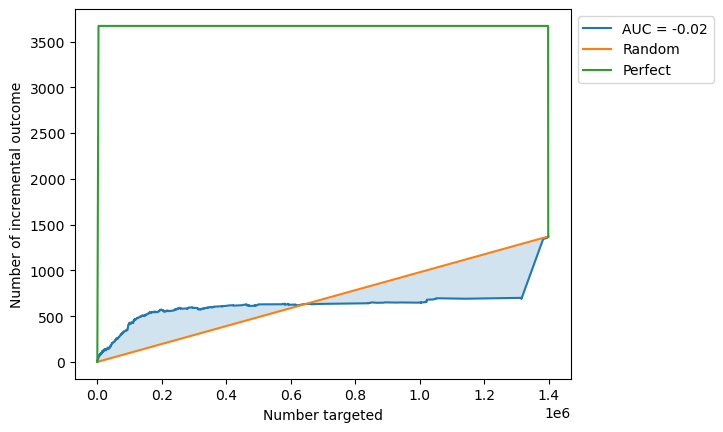

In [11]:
plot_qini_curve(y_holdout, uplift_effect_pred, trmnt_holdout, perfect=True)

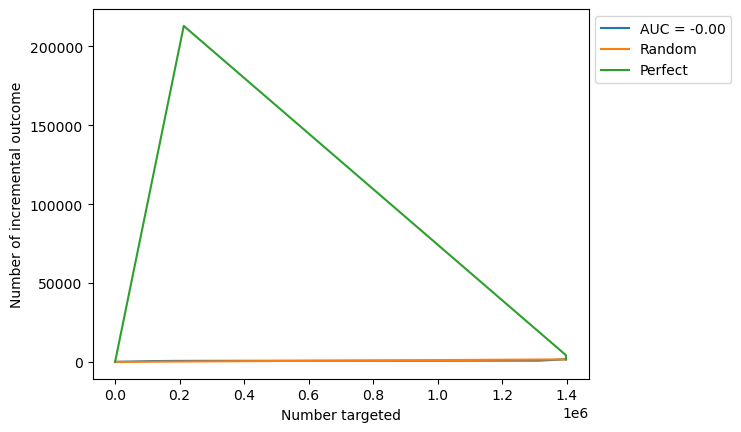

In [12]:
plot_uplift_curve(y_holdout, uplift_effect_pred, trmnt_holdout, perfect=True)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


<AxesSubplot: title={'center': 'Uplift by percentile\nweighted average uplift = 0.0012'}, xlabel='Percentile', ylabel='Uplift = treatment response rate - control response rate'>

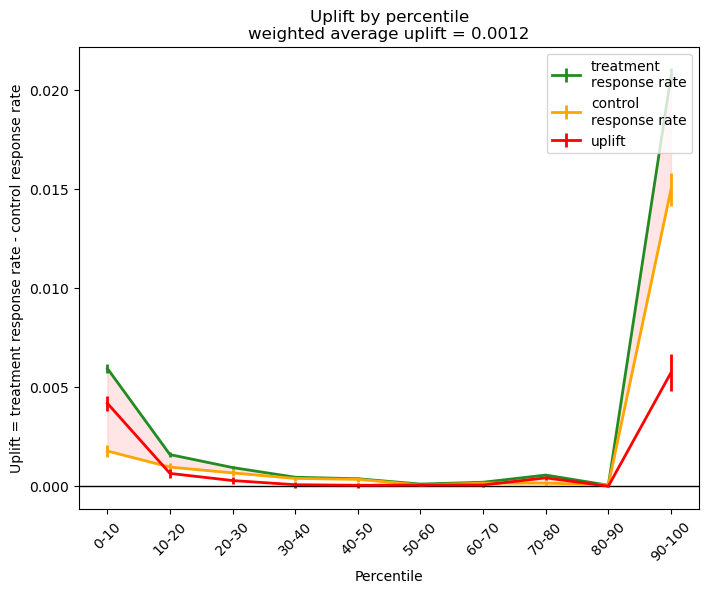

In [13]:
plot_uplift_by_percentile(
    y_holdout, uplift_effect_pred, trmnt_holdout, strategy="overall", bins=10
)

In [14]:
score_if_treatment = model.predict_proba(X_holdout_if_treatment)[:, 1]
score_if_control = model.predict_proba(X_holdout_if_control)[:, 1]
uplift_effect_pred = score_if_treatment - score_if_control

final_result = pd.DataFrame(
    {
        "score_if_treatment": score_if_treatment,
        "score_if_control": score_if_control,
        "uplift_effect_pred": uplift_effect_pred,
        "treatment": trmnt_holdout,
        "conversion": y_holdout,
    }
)
final_result["group"] = final_result["treatment"].apply(
    lambda x: "treatment" if x == 1 else "control"
)
final_result["uplift_score_vntl"] = 20 - pd.qcut(
    final_result["uplift_effect_pred"].rank(method="first"), 20, labels=False
)

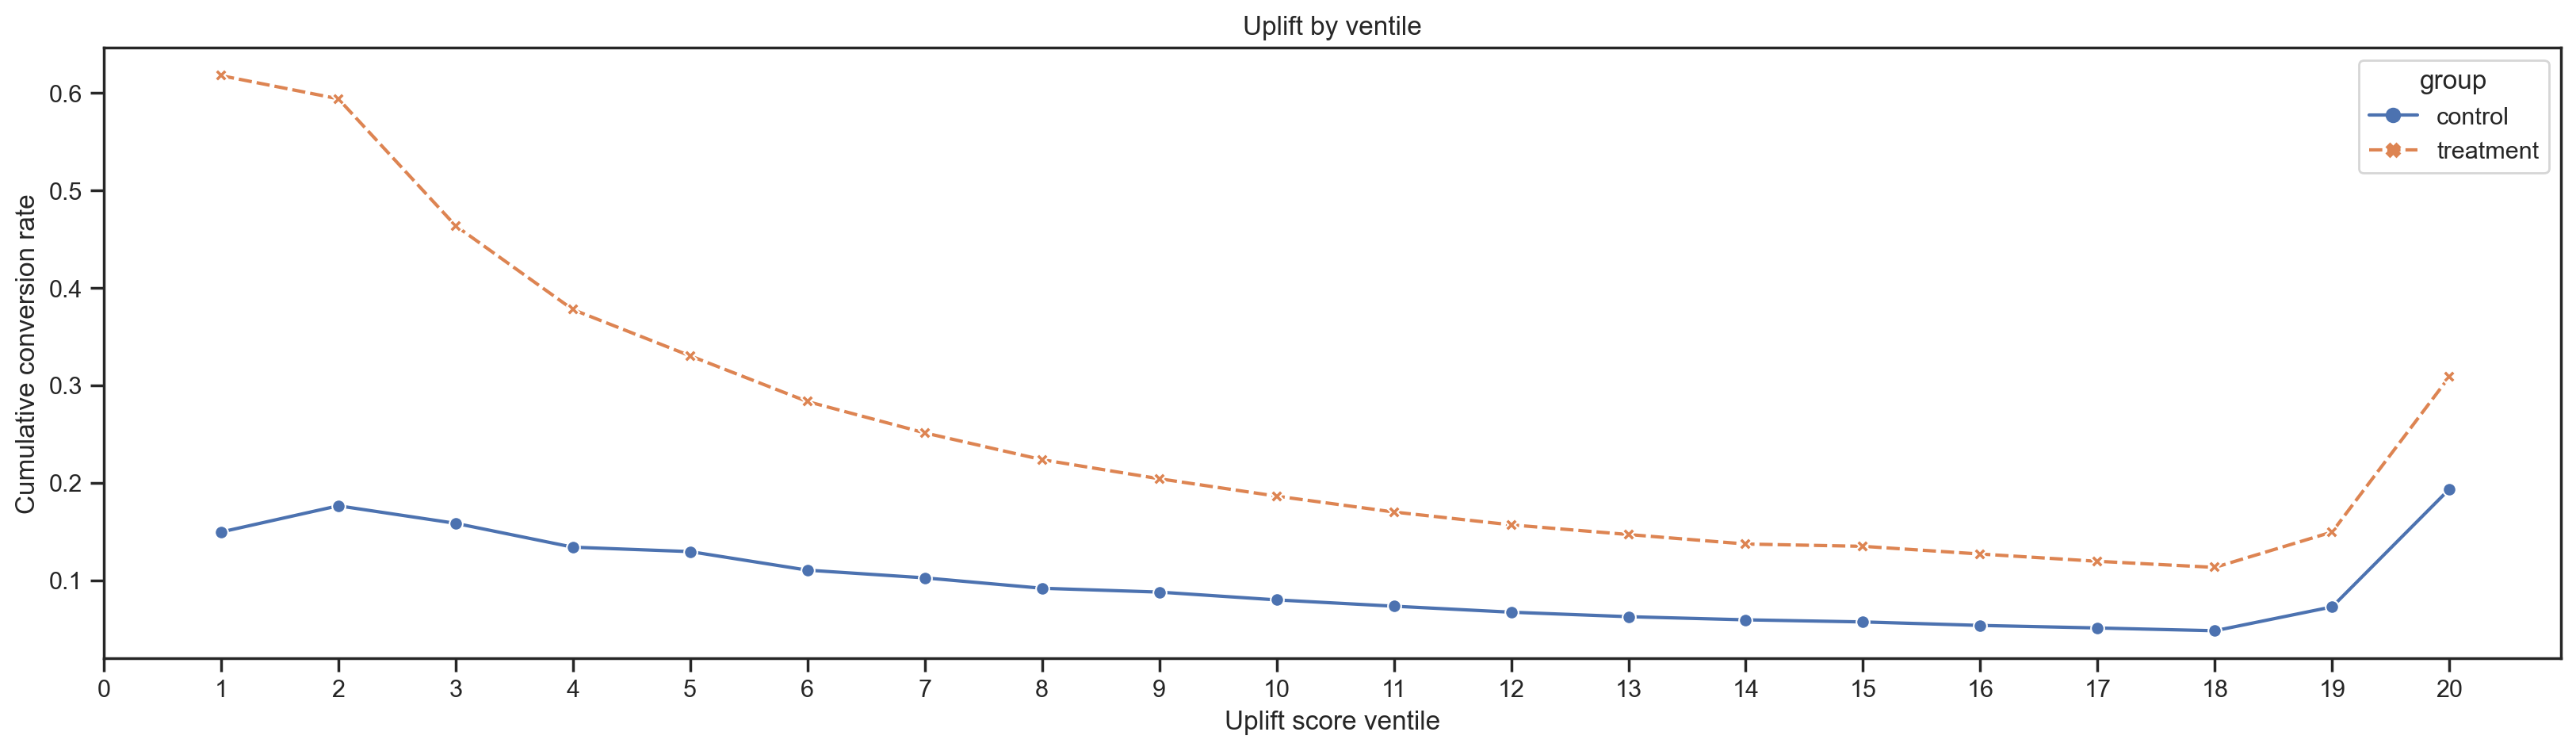

In [15]:
pctl = (
    final_result.groupby(["uplift_score_vntl", "group"])
    .agg(
        base_size=("score_if_control", "count"),
        conversion_rate=("conversion", lambda x: x.mean() * 100),
        takeup_count=("conversion", "sum"),
    )
    .reset_index()
)
pctl["cumulative_takeup_count"] = pctl.groupby("group")["takeup_count"].cumsum()
pctl["cumulative_base_size"] = pctl.groupby("group")["base_size"].cumsum()
pctl["cumulative_conversion_rate"] = (
    pctl["cumulative_takeup_count"] / pctl["cumulative_base_size"] * 100
)

sns.set(style="ticks", font_scale=1)
plt.figure(figsize=(20, 5), dpi=200)
sns.lineplot(
    x=pctl["uplift_score_vntl"],
    y=pctl["cumulative_conversion_rate"],
    hue=pctl["group"],
    style=pctl["group"],
    markers=True,
)
plt.title("Uplift by ventile")
plt.xlabel("Uplift score ventile")
plt.ylabel("Cumulative conversion rate")
plt.xticks(np.arange(0, 21, 1))
plt.show()

## 4.0 Explainability

### 4.1 Feature Importance

In [16]:
importances = model.feature_importances_
features = model.feature_name_

importances_pddf = pd.DataFrame({"feature": features, "importance": importances})
importances_pddf = importances_pddf.sort_values("importance", ascending=False)
importances_pddf.head(10)

,feature,importance
4,f4,1.021601e+09
8,f8,3.379370e+08
2,f2,2.426527e+08
6,f6,1.502438e+08
9,f9,6.598819e+07
3,f3,2.806836e+07
10,f10,1.266048e+07
1,f1,8.751754e+06
7,f7,8.577050e+06
12,f12_trmnt,5.536234e+06


### 4.2 SHAP Values

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


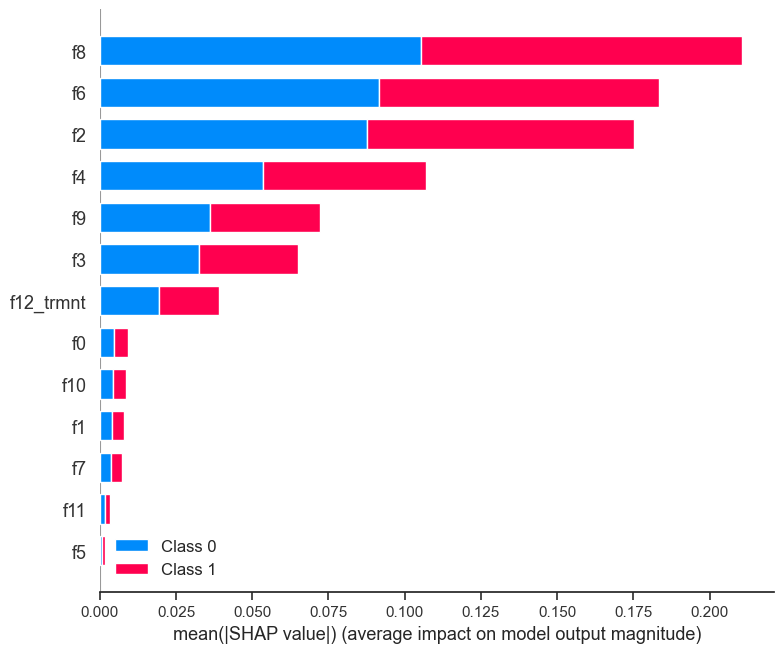

In [17]:
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_train, y_train)

shap.summary_plot(shap_values, X_train)